### List of goals
- Goal 1: clean the signal from artifacts and plan the best strategy for analysis: implement any code that is needed to further clean the signal and think on the best way to achieve goal 2
- Goal 2: decode glucose information from VN recordings: e.g. right before eating, glucose change..

In [1]:
import IPython
# IPython.Application.instance().kernel.do_shutdown(True)

# %matplotlib notebook 
#import mpld3
#mpld3.enable_notebook()

%matplotlib widget

import os
import sys
import json
import time
import datetime
import pycwt
import statistics
import random
import pickle
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import sklearn as sk
import tkinter as tk
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import decomposition
from sklearn.decomposition import PCA
from tkinter import *
from tkinter import ttk
from sklearn import preprocessing
from datetime import date
import matplotlib.dates as mdates

from neurodsp.rhythm import sliding_window_matching
from neurodsp.utils.download import load_ndsp_data
from neurodsp.plts.rhythm import plot_swm_pattern
from neurodsp.plts.time_series import plot_time_series
from neurodsp.utils import set_random_seed, create_times
# Import listed chormap
from matplotlib.colors import ListedColormap
import matplotlib.dates as md
from matplotlib import colors as mcolors
# Scipy
from scipy import signal
from scipy import ndimage
# TKinter for selecting files
from tkinter import Tk     # from tkinter import Tk for Python 3.x
from tkinter.filedialog import askdirectory

# Add my module to python path
sys.path.append("../")

# Own libraries
from Neurogram_short import * # Recording, MyWavelet, MyWaveforms

os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Load data

In [2]:
Tk().withdraw()  # keep the root window from appearing
dir_name = ('../datasets/')
path = '../datasets/rat5/day1' # Port A

map_path = '../datasets/map_linear.csv'

# When using port A: channels=range(0,32,1) by default port B:range(32,64,1)
# Start and dur in samples
# feinstein: channels=[0]
time_start = time.time()
load_from_file=True     # Keep it always to true
downsample = 2          # Only when loading from raw - no need to use it
start= 0                   
dur = None               

port = 'Port A'  # Select port A or B for different recordings
record = Recording.open_record(path, start=start, dur=dur, 
                               load_from_file=load_from_file, 
                               load_multiple_files=True,
                               downsample=downsample,
                               port=port  ,  # Select recording port
                               map_path=map_path,
                               verbose=0)

# Create directory to save figures
if not os.path.exists('%s/figures/' %(path)):
    os.makedirs('%s/figures/' %(path))
print("Time elapsed: {} seconds".format(time.time()-time_start)) 

#sys.exit()


../datasets/rat5/day1
Loading from file C:/Users/airbl/OneDrive - University of Cambridge/Documents/Cambridge Work IIB/IIB Project/Code/code_Peter/datasets/rat5/day1/recording_230718_111958_133858_Port B.pkl
0
stop: 83506752
10000.0
['5', '8', '13']
                                      ch_5       ch_8       ch_13    seconds
time                                                                        
1970-01-01 00:00:00.000000000  1065.479980   7.215000  185.639999     0.0000
1970-01-01 00:00:00.000100000  1102.724976   7.020000  184.860001     0.0001
1970-01-01 00:00:00.000200000  1154.204956  27.105000  218.789993     0.0002
1970-01-01 00:00:00.000300000  1236.689941  56.160000  276.315002     0.0003
1970-01-01 00:00:00.000400000  1271.594971  73.709999  318.825012     0.0004
...                                    ...        ...         ...        ...
1970-01-01 02:19:10.674700000    14.625000  16.184999  -13.065000  8350.6747
1970-01-01 02:19:10.674800000    -6.045000  17.745001  -1

In [3]:
record.recording['seconds']

time
1970-01-01 00:00:00.000000000       0.0000
1970-01-01 00:00:00.000100000       0.0001
1970-01-01 00:00:00.000200000       0.0002
1970-01-01 00:00:00.000300000       0.0003
1970-01-01 00:00:00.000400000       0.0004
                                   ...    
1970-01-01 02:19:10.674700000    8350.6747
1970-01-01 02:19:10.674800000    8350.6748
1970-01-01 02:19:10.674900000    8350.6749
1970-01-01 02:19:10.674999999    8350.6750
1970-01-01 02:19:10.675100000    8350.6751
Name: seconds, Length: 83506752, dtype: float64

In [4]:
# Get current time for saving (avoid overwriting)
now = datetime.datetime.now()
current_time = now.strftime("%d%m%Y_%H%M%S")

In [5]:
## Configuration

In [6]:
# Do not change
options_filter = [
    "None", 
    "butter", 
    "fir"]                # Binomial Weighted Average Filter

options_detection = [
    "get_spikes_threshCrossing", # Ojo: get_spikes_threshCrossing needs detects also cardiac 
                                     # spikes, so use cardiac_window. This method is slower
    "get_spikes_method",         # Python implemented get_spikes() method. Faster
    "so_cfar"]                    # Smallest of constant false-alarm rate filter

options_threshold = [
    "positive",
    "negative", 
    "both_thresh"]

In [7]:
# Configure
config_text = []
record.apply_filter = options_filter[1]    
record.detect_method = options_detection[1]   # leave it to butter (option 1)                                 
record.thresh_type = options_threshold[0]     # do not use it for now
# Select channel position/number in intan (not channel number in device)

record.channels = [5,8,13]  # Select the channels to use. E.g. 5,8,13 for the recording you have now. Include 'all' to select all the channels available

record.path = path  
config_text = ['Load_from_file %s' %load_from_file, 'Filter: %s'%record.apply_filter, 'Detection: %s'%record.detect_method, 'Threhold type: %s'%record.thresh_type, 'Channels: %s' %record.channels, 'Downsampling: %s' %downsample]
config_text.append('Port %s' %(port))
config_text.append('Start %s, Dur: %s' %(start,dur))
config_text.append('Channels: %s' %record.channels)
# Ramarkable timestamps (in sec) 

group = '1'

print('SELECTED GENERAL CONFIGURATION:')
print('Filter: %s'%record.apply_filter)
print('Detection: %s'%record.detect_method)
print('Threhold type: %s'%record.thresh_type)
print('Channels: %s' %record.channels) 
print('-------------------------------------')

record.select_channels(record.channels) # keep_ch_loc=True if we want to display following the map. Otherwise follow the order provided by selected channels.
print('map_array: %s' %record.map_array)
print('ch_loc: %s' %record.ch_loc)
print('filter_ch %s' %record.filter_ch)
print('column_ch %s' %record.column_ch)

SELECTED GENERAL CONFIGURATION:
Filter: butter
Detection: get_spikes_method
Threhold type: positive
Channels: [5, 8, 13]
-------------------------------------
map_array: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
ch_loc: [5, 8, 13]
filter_ch ['ch_5', 'ch_8', 'ch_13']
column_ch ['5', '8', '13']


#### Select visualization options:  

In [8]:
# Configure
record.num_rows = 2 #int(round(len(record.filter_ch)/2)) # round(n_components/2) 
record.num_columns = 1 #int(len(record.filter_ch)-round(len(record.filter_ch)/2))+1 
plot_ch = int(record.map_array[record.ch_loc[0]])                                                
print(plot_ch)
print(record.num_rows)
print(record.num_columns)
save_figure = True

5
2
1


##### Gain

In [9]:
gain = 1
config_text.append('Gain: %s' %(gain))

##### Maximum bpm

In [10]:
bpm = 300
record.set_bpm(bpm) # General max bpm in rat HR. Current neurograms at 180bpm
config_text.append('BPM: %s' %(bpm))

#### Final initializations (No need to change)  

In [11]:
# Initialize dataframe for results 
#----------------------------------------------------
record.rolling_metrics = pd.DataFrame()
record.summary = pd.DataFrame(columns=['Max_spike_rate', 'Min_spike_rate',
                                'Max_amplitude_sum', 'Min_amplitude_sum'])
record.summary.index.name = 'channel'
record.sig2noise = [] #To save the snr for each channel

# Intialize dataframes for wavelet decomposition
#---------------------------------------------------
neural_wvl = pd.DataFrame(columns=record.filter_ch)
neural_wvl_denoised = pd.DataFrame(columns=record.filter_ch)
other_wvl = pd.DataFrame(columns=record.filter_ch)
substraction_wvl = pd.DataFrame(columns=record.filter_ch)

In [12]:
text_label = 'Filtered'
text = 'Channels after %s filtering'%record.apply_filter
record.plot_freq_content(record.filtered, int(plot_ch), nperseg=512, max_freq=4000, ylim=[-100, 100], dtformat='%H:%M:%S',
                         figsize=(10, 10), savefigpath='%s/figures/%s_ch%s_butter_filtering-%s.png' %(record.path, port, plot_ch, current_time))

AttributeError: 'Recording' object has no attribute 'filtered'

### Plot raw signal

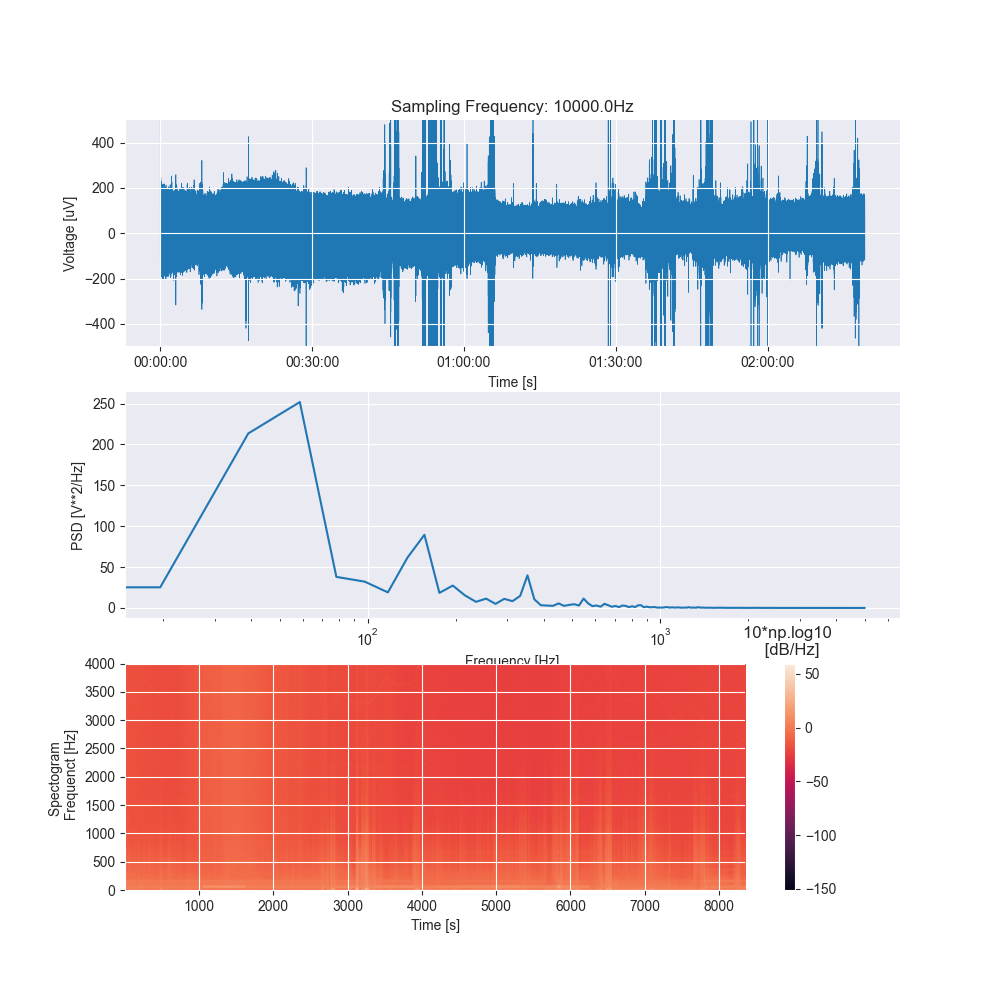

In [13]:
record.plot_freq_content(record.original,int(plot_ch), nperseg=512, max_freq=4000, ylim=[-500, 500], dtformat='%H:%M:%S',
                         figsize=(10, 10), savefigpath='%s/figures/%s_ch%s_original-%s.png' %(record.path, port, plot_ch, current_time), 
                         show=True) 

### Channel referencing

In [14]:
ref_ch_name = 'mean' #'mean'
if ref_ch_name == 'mean':
    # all_ch_list = [col for col in channels if col.startswith('ch_')] 
    all_ch_list = [col for col in record.recording.columns if col.startswith('ch_')] 
    ref_ch = record.original[all_ch_list].mean(axis=1)
else:
    ref_ch = record.original['ch_%s'%ref_ch_name]  
record.referenced = record.original[record.filter_ch].sub(ref_ch, axis=0)
record.referenced['seconds'] = record.original['seconds']
record.recording=record.referenced
record.recording.name = 'referenced'
config_text.append('ref_ch: %s' % ref_ch_name)


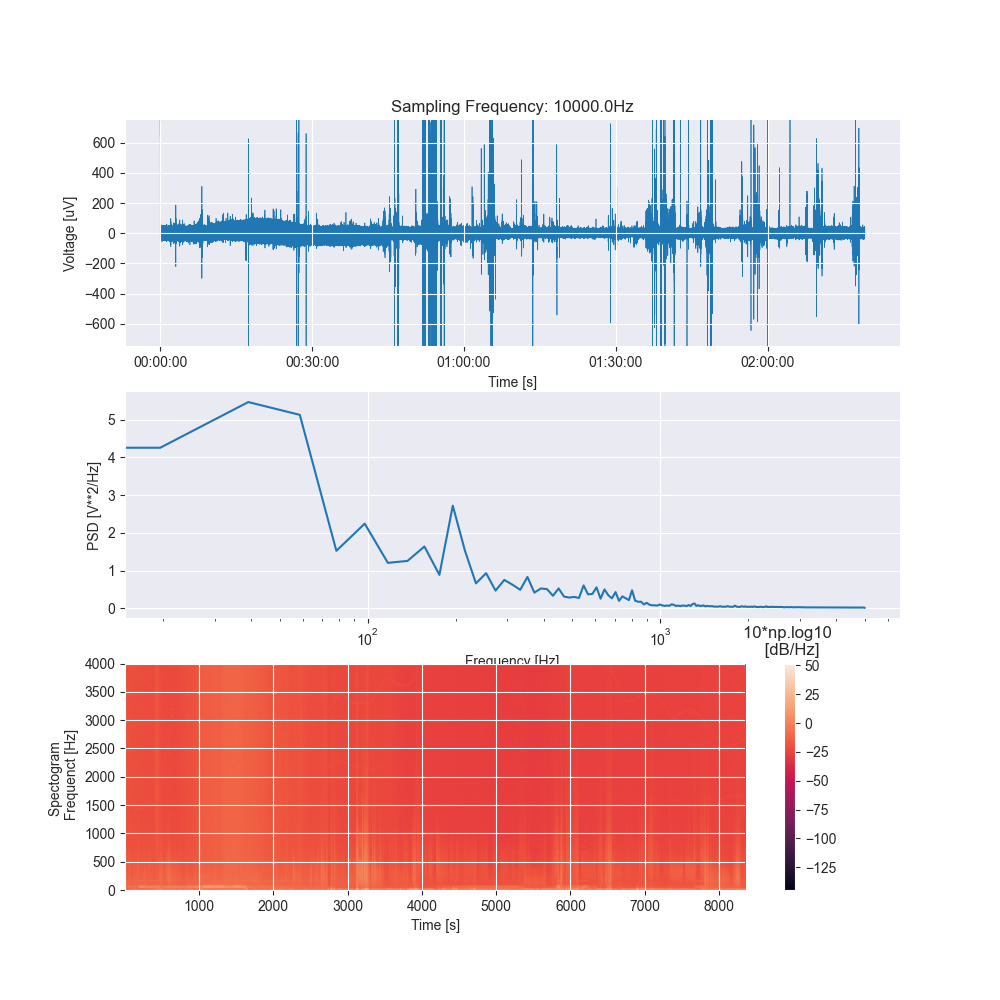

In [15]:
record.plot_freq_content(record.referenced,int(plot_ch), nperseg=512, max_freq=4000, ylim=[-750,750], dtformat='%H:%M:%S',figsize=(10, 10),
                         savefigpath='%s/figures/%s_ch%s_ref%s-%s.png' %(record.path, port, plot_ch, ref_ch_name, current_time),
                         show=True) 
    

### Filtering

#### Bandwidth filter

In [16]:
# Configure - change as needed
filt_config = {
    'W': [400, 4000],  # (max needs to be <fs/2 per Nyquist)
    'None': {},
    'butter': {
            'N': 9,                # The order of the filter
            'btype': 'bandpass', #'bandpass', #'hp'  #'lowpass'     # The type of filter.
    },      
    'fir': {
            'n': 4,
    },
    'notch': {
            'quality_factor': 30,
    },
}

filt_config['butter']['Wn'] = filt_config['W']
filt_config['butter']['fs'] = record.fs

config_text.append('filt_config: %s' %json.dumps(filt_config))

##### Apply filter

In [17]:
# Configure
time_start = time.time()
signal2filter = record.recording
config_text.append('signal2filter: %s' %signal2filter.name)
record.filter(signal2filter, record.apply_filter, **filt_config[record.apply_filter])
# Change from float64 to float 16
record.filtered = convertDfType(record.filtered, typeFloat='float32')
#print(record.filtered.dtypes)
print("Time elapsed: {} seconds".format(time.time()-time_start))

{'N': 9, 'btype': 'bandpass', 'Wn': [400, 4000], 'fs': 10000.0}


NameError: name 'convertDfType' is not defined

##### Plot filtered signal

#### Notch filtering: check if needed

In [ ]:
time_start = time.time()
freq_notch =  range(450, 2000, 100) #change as needed
for n in freq_notch:
    filt_config['notch']['notch_freq'] = n
    record.filter(record.filtered, 'notch', **filt_config['notch'])
print("Time elapsed: {} seconds".format(time.time()-time_start))
config_text.append('notch_filtered:applied')
# Change from float64 to float 16
record.filtered = convertDfType(record.filtered, typeFloat='float32')

record.recording=record.filtered
record.recording.name = 'filtered'

In [ ]:
text_label = 'Filtered'
text = 'Channels after %s filtering'%'notch'

record.plot_freq_content(record.filtered, int(plot_ch), ylim=[-100, 100], nperseg=512, max_freq=4000, dtformat='%H:%M:%S',
                         figsize=(10, 10), savefigpath='%s/figures/%s_ch%s_allfilt-%s.png' %(record.path, port,plot_ch, current_time), show=True) 

### NOISE: Envelope derivative operator (EDO)

In [ ]:
noise_edo=pd.DataFrame()

for ch in record.filter_ch:
    x = record.recording[ch].to_numpy() 
    # Apply EDO filter
    x_e = gen_edo(x)
    # Store in DF to be loaded in signal analysis
    noise_edo[ch] = x_e
noise_edo['seconds'] = np.asarray(record.recording['seconds'])
noise_edo.index = pd.DatetimeIndex(noise_edo.seconds * 1e9)
noise_edo.index.name = 'time'
noise_edo.name = 'noise_edo'

config_text.append('signal to EDO: %s' %record.recording.name)

# Change from float64 to float 32
#noise_edo = convertDfType(noise_edo, typeFloat='float32')
#print(noise_edo.dtypes)